<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/Efficientnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cef4eddb-549f-4c6b-9ae7-69d41a1e1323)


In [38]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Mount + Import library

In [39]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

# Import + Prepare Data

In [42]:
data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo_4class')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1', 'class2', 'class3', 'class4']


In [43]:
class1_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1'
class2_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2'
class3_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3'
class4_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class'

In [ ]:
class1_images = len(os.listdir(class1_dir))
class2_images = len(os.listdir(class2_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class2 images: {class2_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 195
Number of class2 images: 315
Number of class3 images: 201
Number of class4 images: 220


In [44]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1./255,
                              validation_split = 0.3,
                              rotation_range = 40, 
                              horizontal_flip = True, 
                              width_shift_range = 0.2, 
                              height_shift_range = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (240, 240), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (240, 240), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 632 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [45]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(632, 632, (240, 240, 3))

In [46]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(269, 269, (240, 240, 3))

# EfficientNet v2

## Create the base model from the pre-trained convnets

In [ ]:
effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape= None ,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)

33583592/33583592 [==============================] - 1s 0us/step


In [ ]:
# delete last layer
from keras.models import Model
effnet_v2= Model(inputs=effnet_v2.input, outputs=effnet_v2.layers[-2].output)

## Feature Extractor

### Freeze the convolutional base

In [ ]:
effnet_v2.trainable = False

for i,layer in enumerate(effnet_v2.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = rescaling , trainable = False
Layer 2: name = normalization , trainable = False
Layer 3: name = stem_conv , trainable = False
Layer 4: name = stem_bn , trainable = False
Layer 5: name = stem_activation , trainable = False
Layer 6: name = block1a_project_conv , trainable = False
Layer 7: name = block1a_project_bn , trainable = False
Layer 8: name = block1a_project_activation , trainable = False
Layer 9: name = block1b_project_conv , trainable = False
Layer 10: name = block1b_project_bn , trainable = False
Layer 11: name = block1b_project_activation , trainable = False
Layer 12: name = block1b_drop , trainable = False
Layer 13: name = block1b_add , trainable = False
Layer 14: name = block2a_expand_conv , trainable = False
Layer 15: name = block2a_expand_bn , trainable = False
Layer 16: name = block2a_expand_activation , trainable = False
Layer 17: name = block2a_project_conv , trainable = False
Layer 18: name = block2a_project_b

### Add a classification head

In [ ]:
x = effnet_v2.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 120, 120, 32  864         ['normalization[0][0]']    

Plot Model

In [ ]:
tf.keras.utils.plot_model(model, to_file='effnet_org.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Compile the model

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

### Train the model

In [ ]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.4108 - acc: 0.2851
Epoch 1: val_acc improved from -inf to 0.24211, saving model to weights.hdf5
45/45 [==============================] - 19s 102ms/step - loss: 1.4108 - acc: 0.2851 - val_loss: 1.4256 - val_acc: 0.2421
Epoch 2/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4202 - acc: 0.2628
Epoch 2: val_acc improved from 0.24211 to 0.29474, saving model to weights.hdf5
45/45 [==============================] - 2s 55ms/step - loss: 1.4182 - acc: 0.2624 - val_loss: 1.4051 - val_acc: 0.2947
Epoch 3/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4241 - acc: 0.2628
Epoch 3: val_acc improved from 0.29474 to 0.34737, saving model to weights.hdf5
45/45 [==============================] - 2s 53ms/step - loss: 1.4255 - acc: 0.2624 - val_loss: 1.4257 - val_acc: 0.3474
Epoch 4/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4122 - acc: 0.2860
Epoch 4: val_acc did not improve from 0.34737

### Learning curves

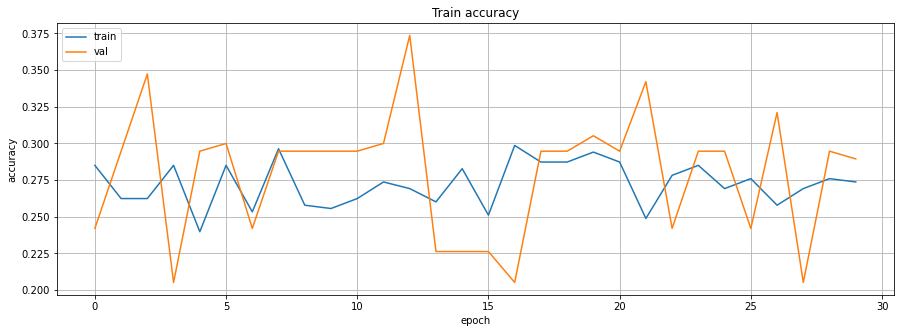

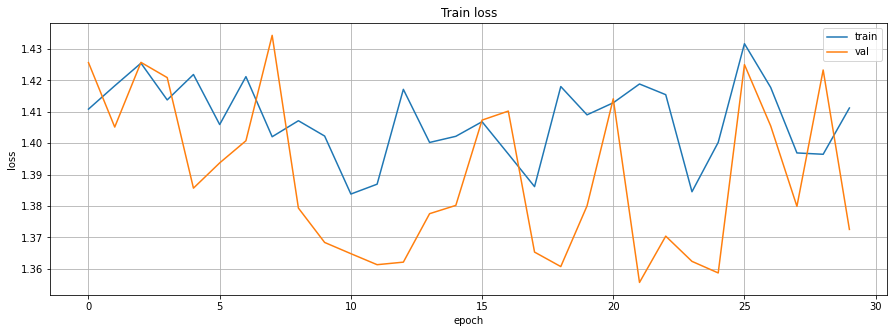

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [ ]:
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 3s 124ms/step - loss: 1.3786 - acc: 0.3532
['loss', 'acc']: [1.3785761594772339, 0.3531598448753357]
Duration: 0:00:03.645900


### Evaluate on test set without seed

In [93]:

effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(weights = "imagenet", include_top=True)
effnet_v2= Model(inputs=effnet_v2.input, outputs=effnet_v2.layers[-2].output)
effnet_v2.trainable = False

# add classifier
x = effnet_v2.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

#train model without seed
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)
history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
43/45 [===========================>..] - ETA: 0s - loss: 1.4064 - acc: 0.2907
Epoch 1: val_acc improved from -inf to 0.24211, saving model to weights.hdf5
45/45 [==============================] - 12s 100ms/step - loss: 1.4070 - acc: 0.2919 - val_loss: 1.4345 - val_acc: 0.2421
Epoch 2/10
43/45 [===========================>..] - ETA: 0s - loss: 1.4232 - acc: 0.2349
Epoch 2: val_acc improved from 0.24211 to 0.29474, saving model to weights.hdf5
45/45 [==============================] - 2s 54ms/step - loss: 1.4206 - acc: 0.2376 - val_loss: 1.4023 - val_acc: 0.2947
Epoch 3/10
43/45 [===========================>..] - ETA: 0s - loss: 1.4143 - acc: 0.2419
Epoch 3: val_acc did not improve from 0.29474
45/45 [==============================] - 2s 44ms/step - loss: 1.4161 - acc: 0.2398 - val_loss: 1.4256 - val_acc: 0.2421
Epoch 4/10
43/45 [===========================>..] - ETA: 0s - loss: 1.4017 - acc: 0.2791
Epoch 4: val_acc did not improve from 0.29474
45/45 [==========================

## Fine tuning


### Create feature extractor + un-freeze all layers

In [74]:
img_w,img_h = 240,240
effnet_v2 = effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape= (img_w, img_h, 3) ,
    pooling="max",
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)
effnet_v2.trainable = True

### Add a classification head

In [75]:
x = effnet_v2.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8192, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

In [51]:
for i,layer in enumerate(model.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_8 , trainable = True
Layer 1: name = rescaling_7 , trainable = True
Layer 2: name = normalization_7 , trainable = True
Layer 3: name = stem_conv , trainable = True
Layer 4: name = stem_bn , trainable = True
Layer 5: name = stem_activation , trainable = True
Layer 6: name = block1a_project_conv , trainable = True
Layer 7: name = block1a_project_bn , trainable = True
Layer 8: name = block1a_project_activation , trainable = True
Layer 9: name = block1b_project_conv , trainable = True
Layer 10: name = block1b_project_bn , trainable = True
Layer 11: name = block1b_project_activation , trainable = True
Layer 12: name = block1b_drop , trainable = True
Layer 13: name = block1b_add , trainable = True
Layer 14: name = block2a_expand_conv , trainable = True
Layer 15: name = block2a_expand_bn , trainable = True
Layer 16: name = block2a_expand_activation , trainable = True
Layer 17: name = block2a_project_conv , trainable = True
Layer 18: name = block2a_project_bn , trainable 

### Compile the model

In [76]:
opt = tf.keras.optimizers.Adamax(learning_rate = 0.001)
model.compile( loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])

### Train the model

In [77]:
from datetime import datetime
start_time = datetime.now()

#np.random.seed(1234)
#tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 9.7078 - acc: 0.2941
Epoch 1: val_acc improved from -inf to 0.29474, saving model to weights.hdf5
45/45 [==============================] - 20s 196ms/step - loss: 9.7078 - acc: 0.2941 - val_loss: 1.3688 - val_acc: 0.2947
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.2820 - acc: 0.4344
Epoch 2: val_acc improved from 0.29474 to 0.49474, saving model to weights.hdf5
45/45 [==============================] - 7s 164ms/step - loss: 1.2820 - acc: 0.4344 - val_loss: 1.1952 - val_acc: 0.4947
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.0737 - acc: 0.5181
Epoch 3: val_acc improved from 0.49474 to 0.53158, saving model to weights.hdf5
45/45 [==============================] - 7s 151ms/step - loss: 1.0737 - acc: 0.5181 - val_loss: 1.0302 - val_acc: 0.5316
Epoch 4/30
45/45 [==============================] - ETA: 0s - loss: 0.9515 - acc: 0.5860
Epoch 4: val_acc improved from 0.53158 to 0

### Learning curves

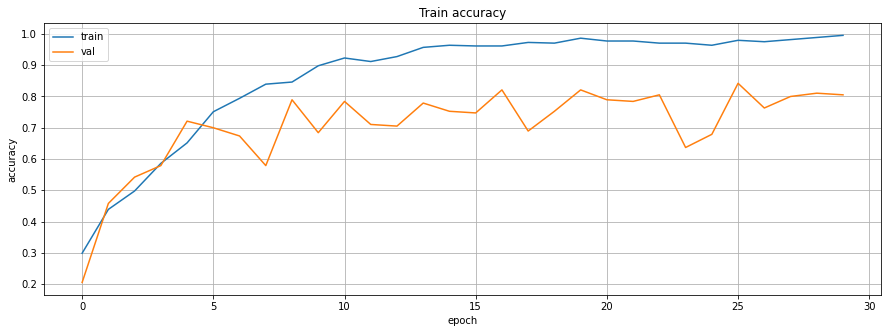

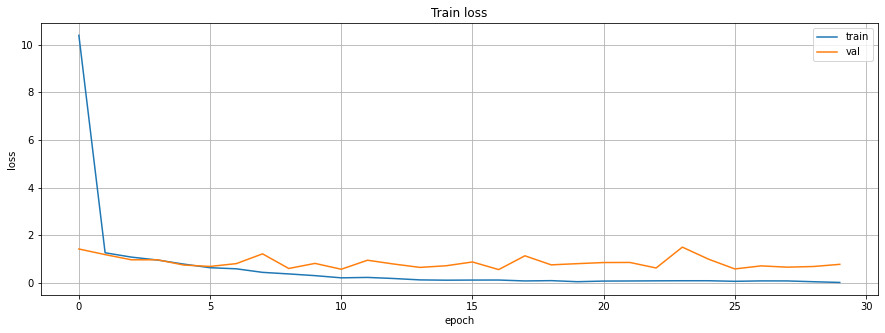

In [53]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [52]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 3s 79ms/step - loss: 1.2383 - acc: 0.6914
['loss', 'acc']: [1.2382962703704834, 0.6914498209953308]
Duration: 0:00:02.710589


### Evaluate on test set without seed

In [86]:
img_w,img_h = 240,240
effnet_v2 = effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape= (img_w, img_h, 3) ,
    pooling="max",
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)
effnet_v2.trainable = True

In [88]:
x = effnet_v2.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8192, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

In [89]:
for i,layer in enumerate(model.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_14 , trainable = True
Layer 1: name = rescaling_13 , trainable = True
Layer 2: name = normalization_13 , trainable = True
Layer 3: name = stem_conv , trainable = True
Layer 4: name = stem_bn , trainable = True
Layer 5: name = stem_activation , trainable = True
Layer 6: name = block1a_project_conv , trainable = True
Layer 7: name = block1a_project_bn , trainable = True
Layer 8: name = block1a_project_activation , trainable = True
Layer 9: name = block1b_project_conv , trainable = True
Layer 10: name = block1b_project_bn , trainable = True
Layer 11: name = block1b_project_activation , trainable = True
Layer 12: name = block1b_drop , trainable = True
Layer 13: name = block1b_add , trainable = True
Layer 14: name = block2a_expand_conv , trainable = True
Layer 15: name = block2a_expand_bn , trainable = True
Layer 16: name = block2a_expand_activation , trainable = True
Layer 17: name = block2a_project_conv , trainable = True
Layer 18: name = block2a_project_bn , trainab

In [90]:
opt = tf.keras.optimizers.Adamax(learning_rate = 0.001)
model.compile( loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])

In [91]:
from datetime import datetime
start_time = datetime.now()

#np.random.seed(1234)
#tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 9.8636 - acc: 0.3009
Epoch 1: val_acc improved from -inf to 0.24737, saving model to weights.hdf5
45/45 [==============================] - 22s 198ms/step - loss: 9.8636 - acc: 0.3009 - val_loss: 1.3922 - val_acc: 0.2474
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.2278 - acc: 0.4751
Epoch 2: val_acc improved from 0.24737 to 0.46316, saving model to weights.hdf5
45/45 [==============================] - 7s 162ms/step - loss: 1.2278 - acc: 0.4751 - val_loss: 1.1696 - val_acc: 0.4632
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.0991 - acc: 0.5226
Epoch 3: val_acc improved from 0.46316 to 0.52105, saving model to weights.hdf5
45/45 [==============================] - 7s 150ms/step - loss: 1.0991 - acc: 0.5226 - val_loss: 1.0250 - val_acc: 0.5211
Epoch 4/30
45/45 [==============================] - ETA: 0s - loss: 1.0107 - acc: 0.5543
Epoch 4: val_acc did not improve from 0.521

In [85]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 3s 80ms/step - loss: 1.5756 - acc: 0.6506
['loss', 'acc']: [1.575554609298706, 0.6505576372146606]
Duration: 0:00:03.279031
